In [1]:
import scanpy as sc
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import bbknn
import scipy.stats
import numpy as np

In [2]:
import sys
sys.path.insert(0, "../lib")

In [3]:
import sc_utils

In [4]:
mpl.rcParams["figure.figsize"] = (16, 12)
pd.set_option('display.max_rows', 1000)

Load preprint object

In [5]:
prev = sc.read_h5ad("../data/02preprint/10obj-named.h5ad")

Load revision object after cleaning doublets and low-quality clusters (see 01filtering.ipynb) & after correcting every sample with FastCAR (see Snakefile) after seeing IGLV* expression in macrophages

In [6]:
ds = sc.read_h5ad("../data/04dataset/02obj.h5ad")

In [7]:
ds.shape

(111751, 21823)

Add common metadata

In [8]:
ds.obs["cluster"] = "Unknown"

In [9]:
prev_cluster = prev.obs.cluster
prev_cluster = prev_cluster.loc[prev_cluster.index.isin(ds.obs_names)]

In [10]:
ds.obs.loc[prev_cluster.index, "cluster"] = prev_cluster

In [11]:
ds.obs["COVID-19"] = True
ds.obs.loc[ds.obs["orig.ident"].isin([
    "Sample_8", "Sample_9", "Sample_10", "Sample_11"
]), "COVID-19"] = False

In [13]:
ds.obs["COVID-19"] = ds.obs["COVID-19"].astype("category")
ds.obs["patient"] = ds.obs["patient"].astype("category")

In [14]:
sars_genes = ds.var_names[ds.var_names.str.startswith("SARS-CoV-2")]
sars_detected = (ds.raw.X[:, ds.var_names.isin(sars_genes)].todense() > 0).sum(axis=1).A[:, 0]
ds.obs["n_sars_genes"] = sars_detected

In [15]:
ds.obs["sample_status"] = "Cryo"
ds.obs.loc[ds.obs["orig.ident"].isin(prev.obs["orig.ident"].unique()), "sample_status"] = "Fresh"
ds.obs.sample_status = ds.obs.sample_status.astype("category")

In [16]:
ds.obs["celltype"] = ""

## Load genotype info for Sample_16

In [17]:
sample_16 = pd.read_csv("../data/03raw-data/souporcell/Sample_16/clusters.tsv", sep="\t", index_col=0)

In [18]:
sample_16.index = "Sample_16_" + sample_16.index.str.replace("-\d+$", "")

In [19]:
sample_16

status assignment  log_prob_singleton  \
barcode                                                              
Sample_16_AAACCTGAGAAGATTC  singlet          1          -21.821187   
Sample_16_AAACCTGAGAATCTCC  singlet          1          -79.945016   
Sample_16_AAACCTGAGATAGCAT  singlet          1          -17.990679   
Sample_16_AAACCTGAGCCCGAAA  singlet          1          -58.455904   
Sample_16_AAACCTGAGGACAGAA  singlet          1          -24.331308   
...                             ...        ...                 ...   
Sample_16_TTTGTCATCATTGCGA  singlet          1          -11.113716   
Sample_16_TTTGTCATCCAGTATG  singlet          1          -72.099500   
Sample_16_TTTGTCATCTCCAGGG  singlet          1         -114.555619   
Sample_16_TTTGTCATCTGTCTAT  singlet          0          -70.108726   
Sample_16_TTTGTCATCTTGAGGT  singlet          1          -49.617586   

                            log_prob_doublet     cluster0    cluster1  
barcode                                                                
Sample_16_AAACCTGAGAAGATTC        -30.338752   -76.826876  -21.821187  
Sample_16_AAACCTGAGAATCTCC       -111.324754  -260.385228  -79.945016  
Sample_16_AAACCTGAGATAGCAT        -27.544660   -64.345918  -17.990679  
Sample_16_AAACCTGAGCCCGAAA        -79.934708  -182.927550  -58.455904  
Sample_16_AAACCTGAGGACAGAA        -30.286057   -76.814899  -24.331308  
...                                      ...          ...         ...  
Sample_16_TTTGTCATCATTGCGA        -16.697416   -34.567660  -11.113716  
Sample_16_TTTGTCATCCAGTATG       -121.178138  -334.617352  -72.099500  
Sample_16_TTTGTCATCTCCAGGG       -727.192723 -4276.568564 -114.555619  
Sample_16_TTTGTCATCTGTCTAT       -113.261086   -70.108726 -349.173429  
Sample_16_TTTGTCATCTTGAGGT        -68.513846  -147.511458  -49.617586  

[17384 rows x 6 columns]

Assign cells into Cluster 0, Cluster 1 and To remove categories. To remove includes doublets & unassigned cells from souporcell

In [20]:
cluster0_cells = sample_16.index[(sample_16.status == "singlet") & (sample_16.assignment == "0")]
cluster1_cells = sample_16.index[(sample_16.status == "singlet") & (sample_16.assignment == "1")]

In [21]:
cluster0_cells.size

5850

In [22]:
cluster1_cells.size

10095

In [23]:
to_remove = sample_16.index[sample_16.status != "singlet"]

Have we picked all cells?

In [41]:
to_remove.size + cluster0_cells.size + cluster1_cells.size == sample_16.shape[0]

True

In [43]:
already_excluded = pd.read_csv("01cells-to-exclude.csv", index_col=0)

cells_to_exclude = pd.Series(ds.obs_names[ds.obs_names.isin(to_remove)])

pd.concat([pd.Series(already_excluded.index), cells_to_exclude], axis=0).to_csv(
    "02cells-to-exclude.csv",
    index=False,
    header=False
)

## Plot main plots:

clusters from preprint

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cluster' as categorical


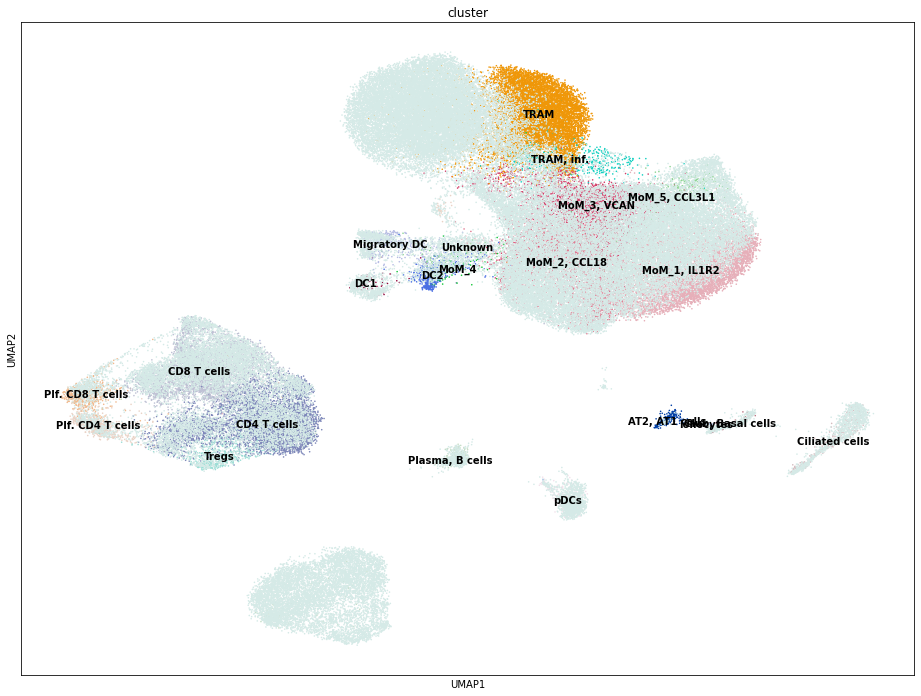

In [14]:
sc.pl.umap(ds, color="cluster", size=10, legend_loc="on data")

COVID-19 status

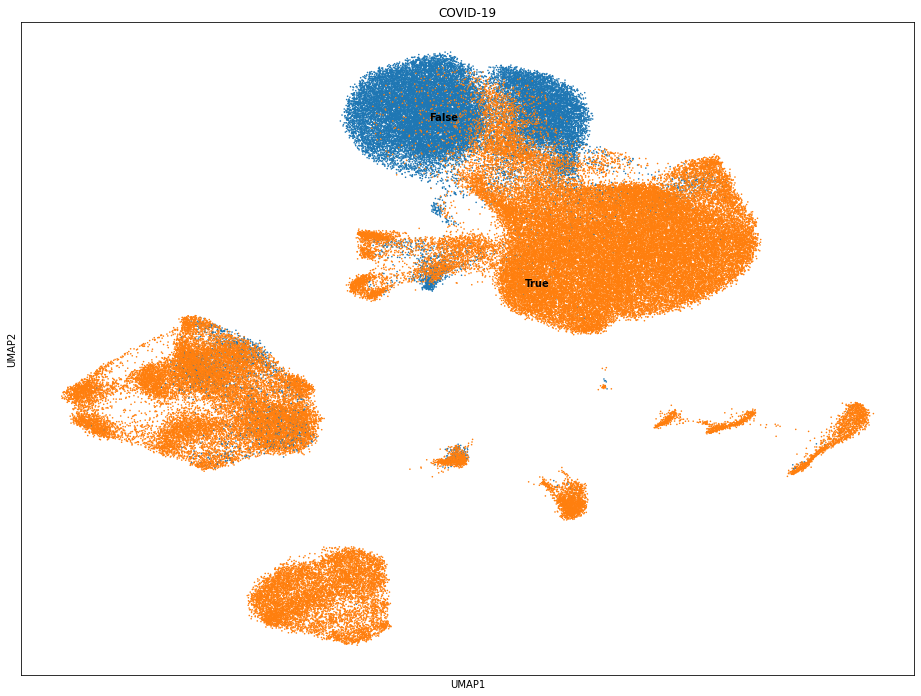

In [15]:
sc.pl.umap(ds, color="COVID-19", size=10, legend_loc="on data")

Patient

... storing 'cluster' as categorical
... storing 'celltype' as categorical


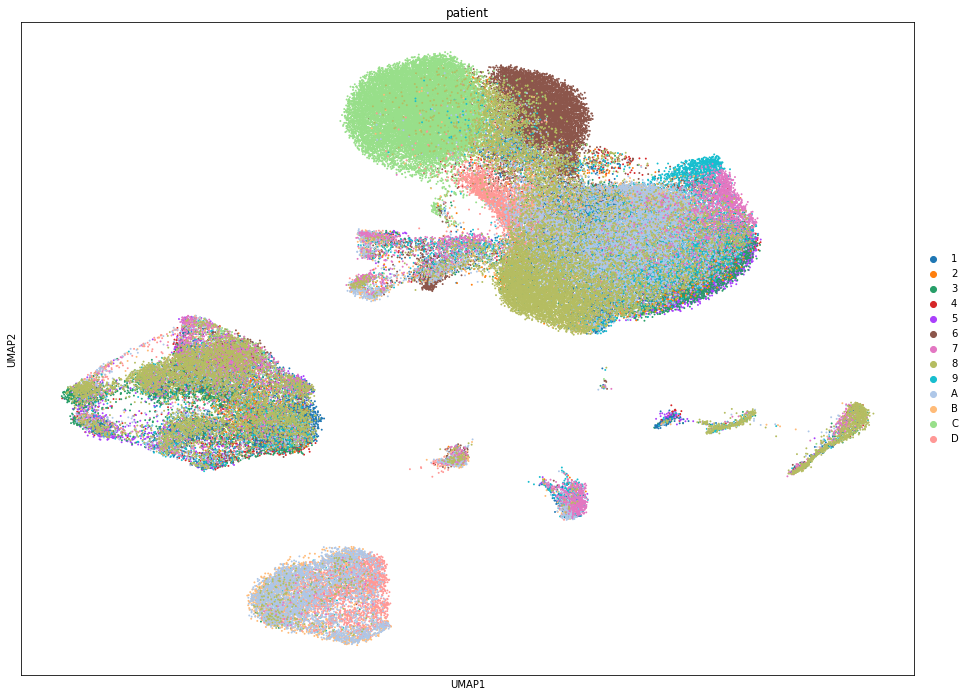

In [20]:
sc.pl.umap(ds, color="patient", size=15)

Sample status: fresh / cryo

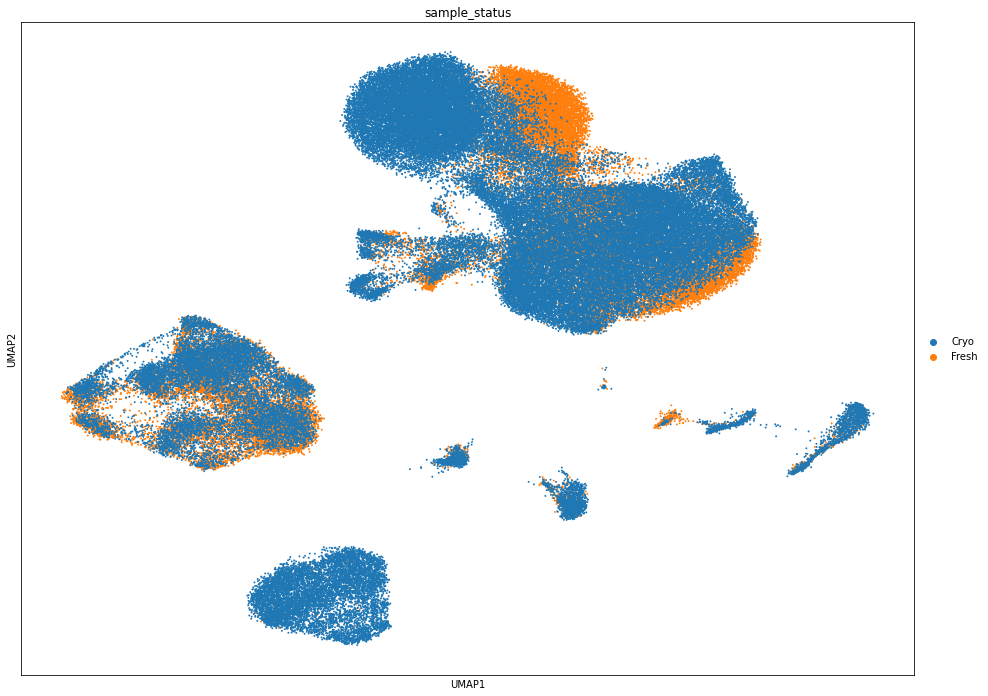

In [17]:
sc.pl.umap(ds, color="sample_status", size=15)

## Fresh / cryo samples difference

nUMIs vs nGenes plot

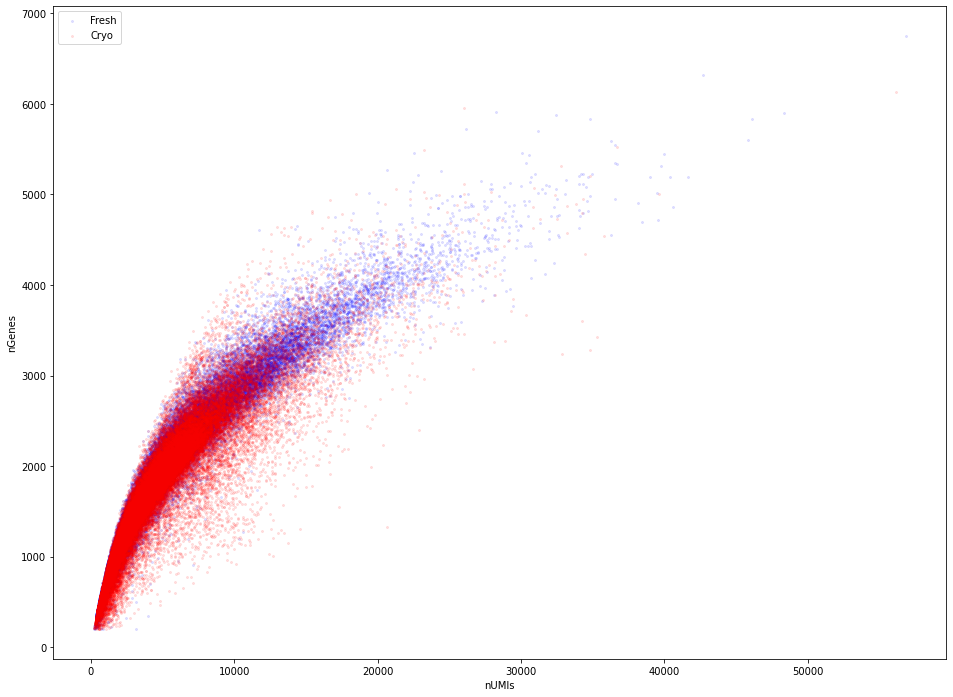

In [18]:
fig, ax = plt.subplots()
ax.scatter(ds.obs.total_counts[ds.obs.sample_status == "Fresh"], 
           ds.obs.n_genes_by_counts[ds.obs.sample_status == "Fresh"],
           c="b", alpha=0.1, s=4, label="Fresh")
ax.scatter(ds.obs.total_counts[ds.obs.sample_status == "Cryo"], 
           ds.obs.n_genes_by_counts[ds.obs.sample_status == "Cryo"],
           c="r", alpha=0.1, s=4, label="Cryo")
ax.set_xlabel("nUMIs")
ax.set_ylabel("nGenes")
ax.legend()

So Fresh samples reach out to higher values for both variables

nUMIs violin plot

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


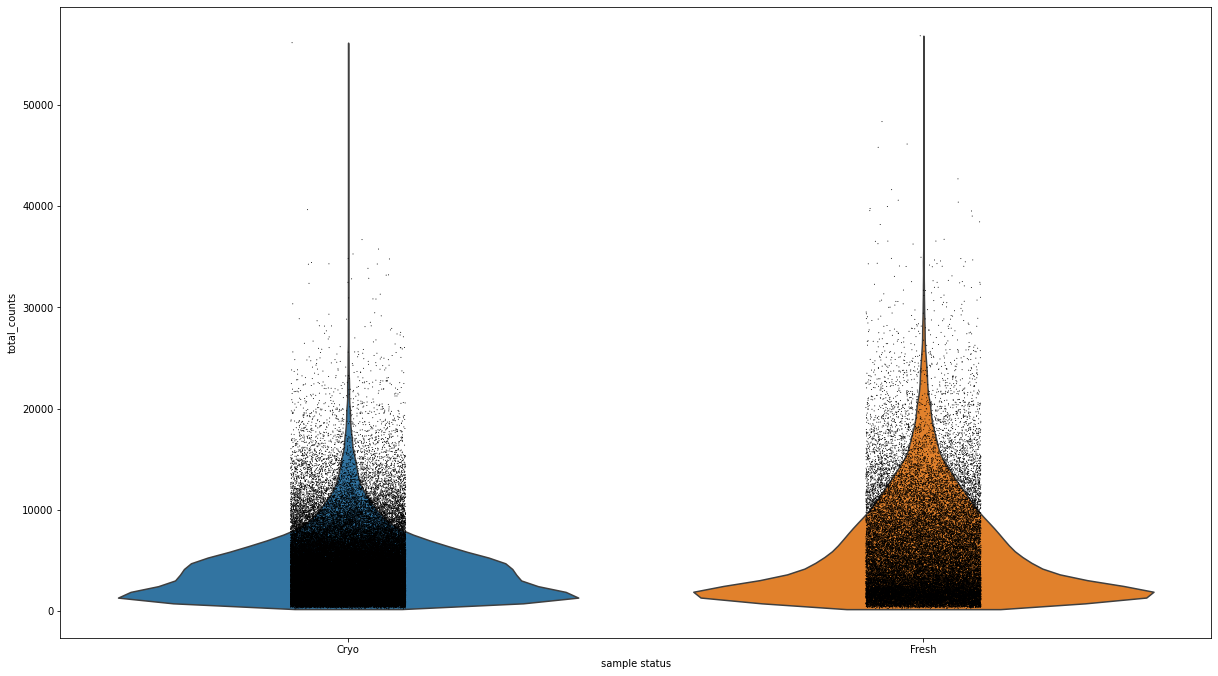

In [19]:
sc.pl.violin(ds, "total_counts", "sample_status")

% mito violin plot

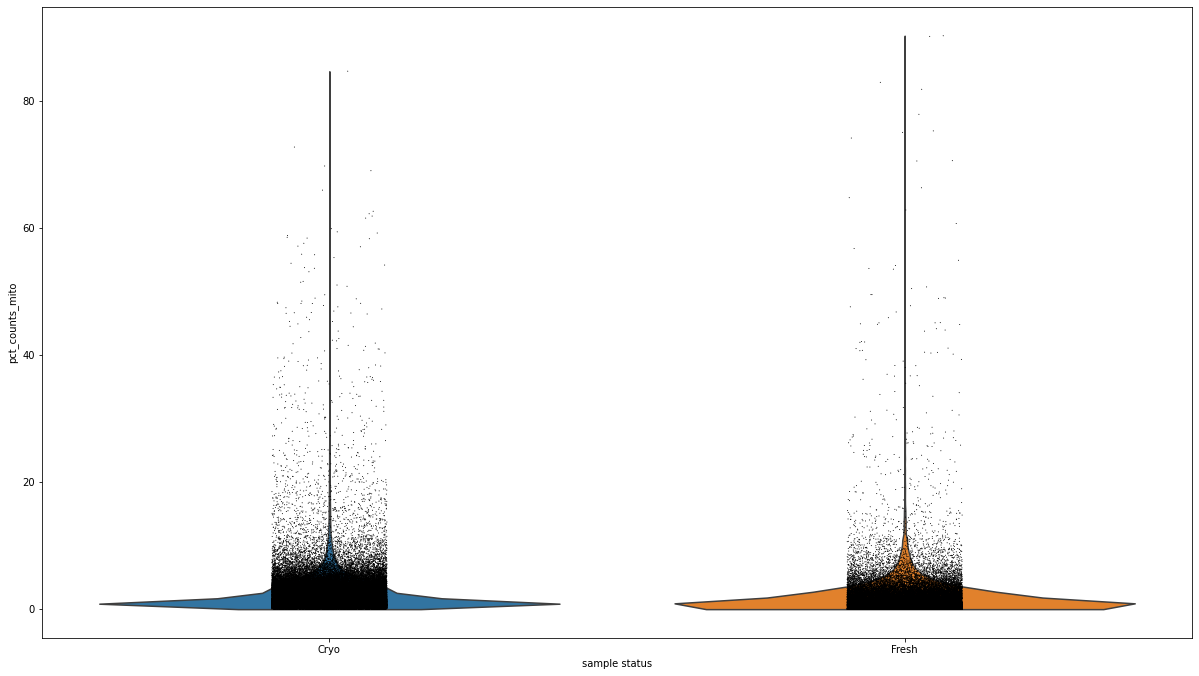

In [21]:
sc.pl.violin(ds, "pct_counts_mito", "sample_status")

nGenes violin plot

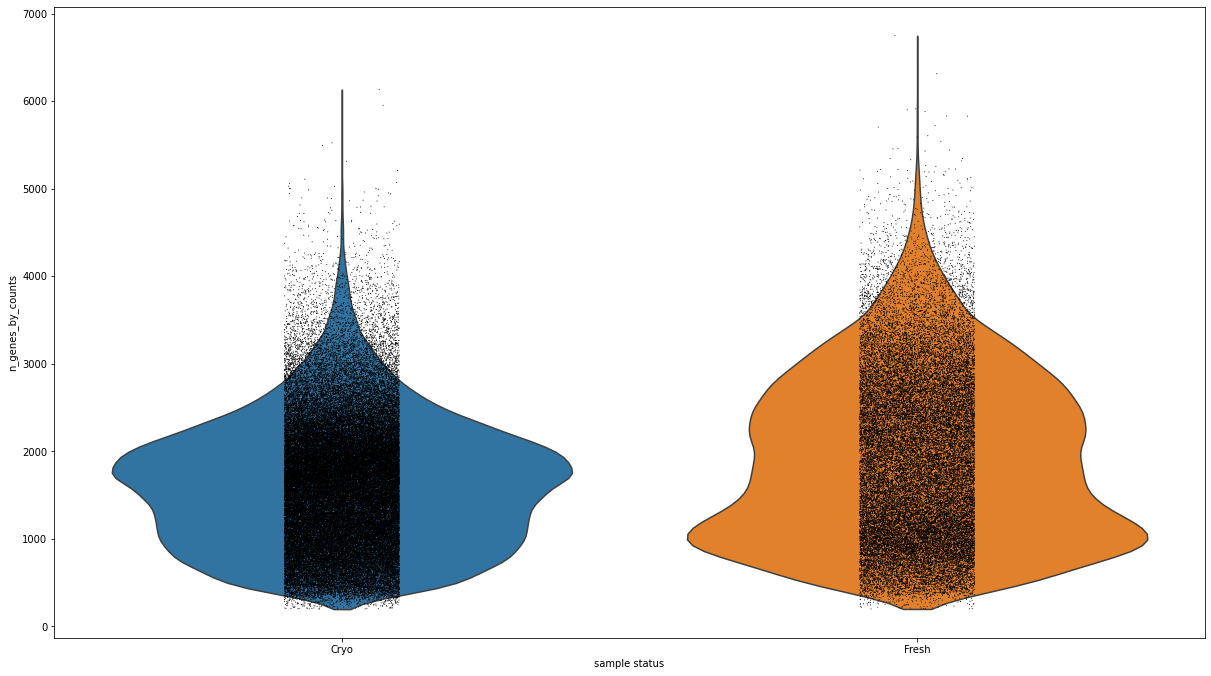

In [21]:
sc.pl.violin(ds, "n_genes_by_counts", "sample_status")

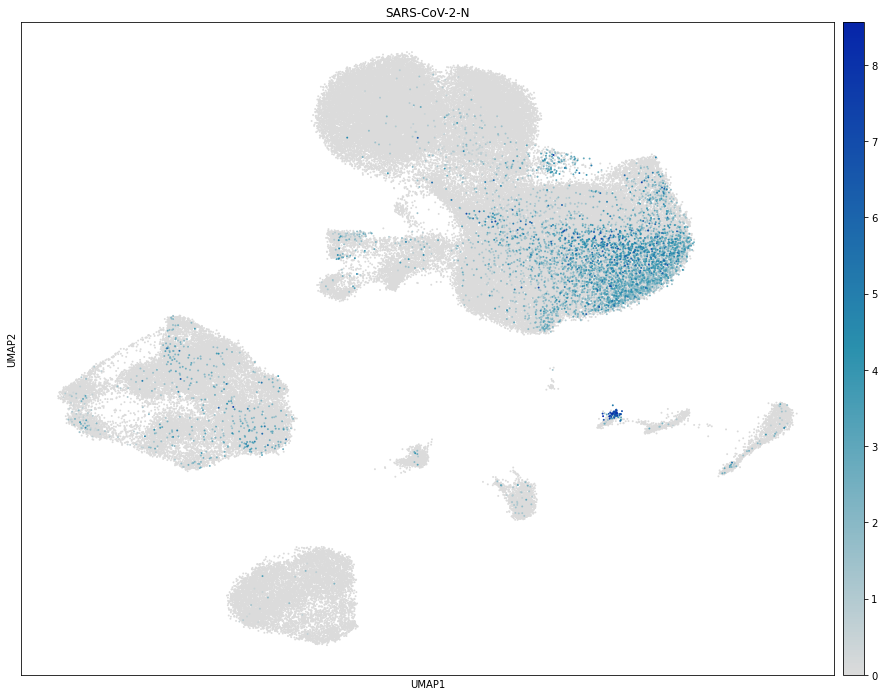

In [22]:
sc.pl.umap(ds, color="SARS-CoV-2-N", size=15, cmap=sc_utils.expr_colormap())

## Plot technical variables

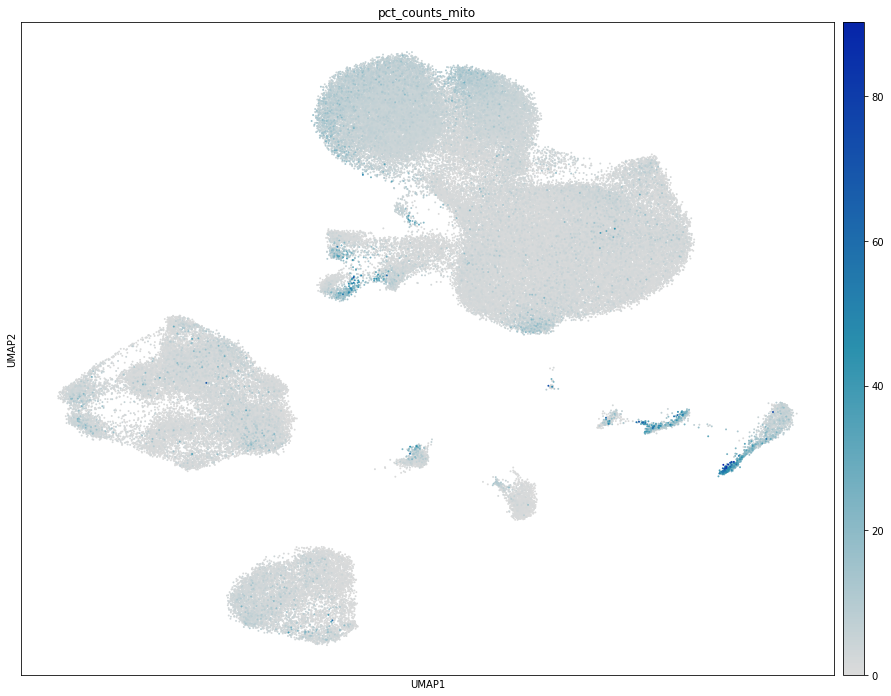

In [23]:
sc.pl.umap(ds, color="pct_counts_mito", size=15, cmap=sc_utils.expr_colormap())

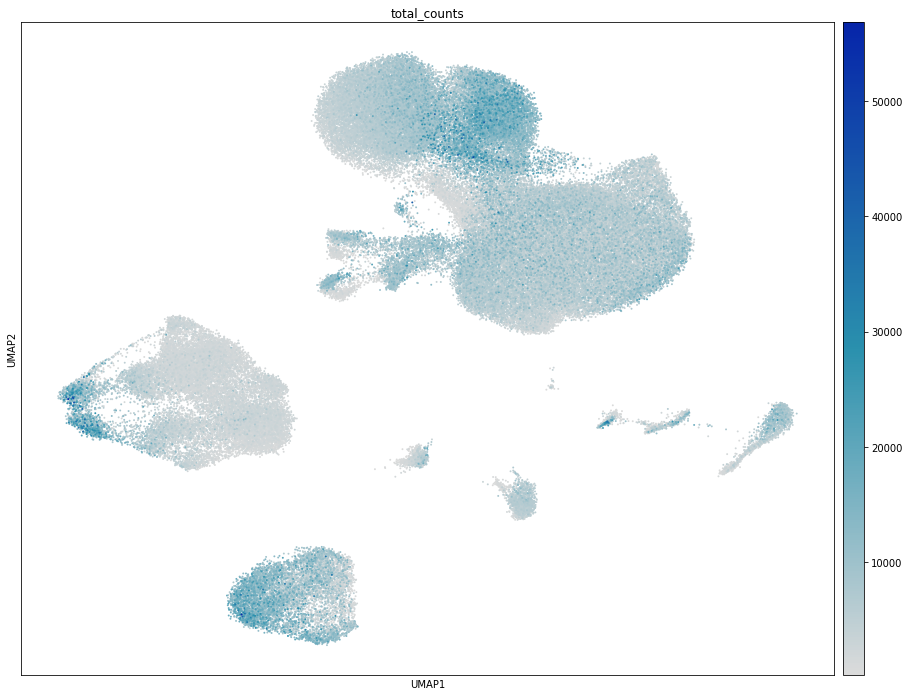

In [24]:
sc.pl.umap(ds, color="total_counts", size=15, cmap=sc_utils.expr_colormap())

Default low-resolution

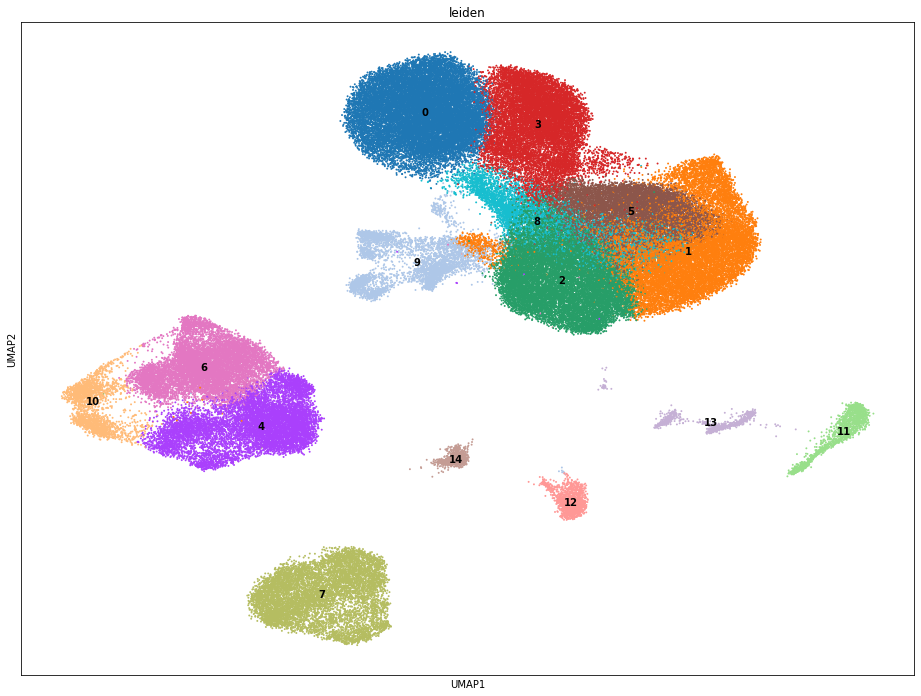

In [25]:
sc.pl.umap(ds, 
           color="leiden", 
           size=15, 
           legend_loc="on data")

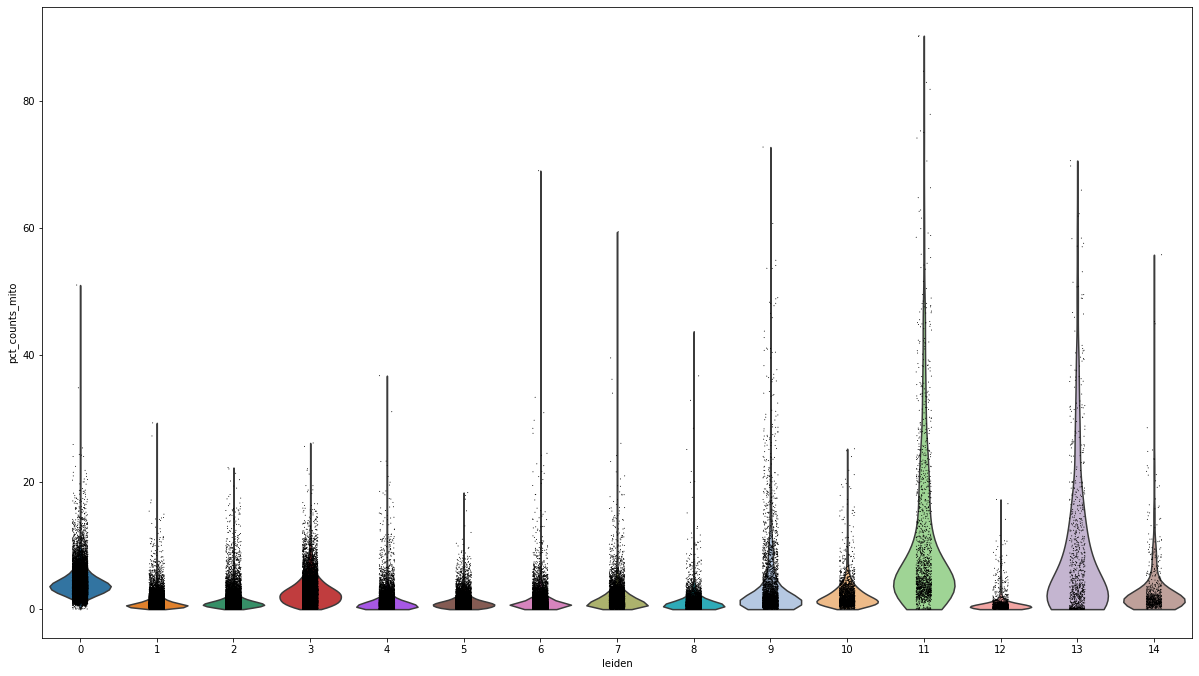

In [26]:
sc.pl.violin(ds, "pct_counts_mito", "leiden")

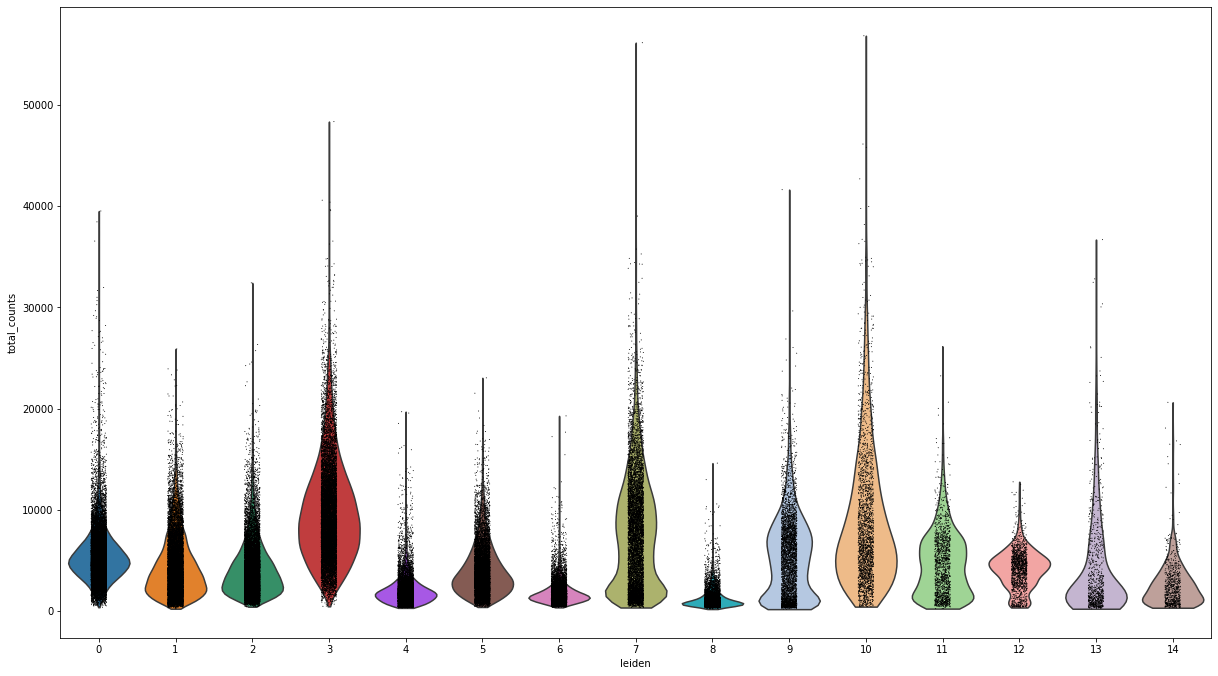

In [27]:
sc.pl.violin(ds, "total_counts", "leiden")

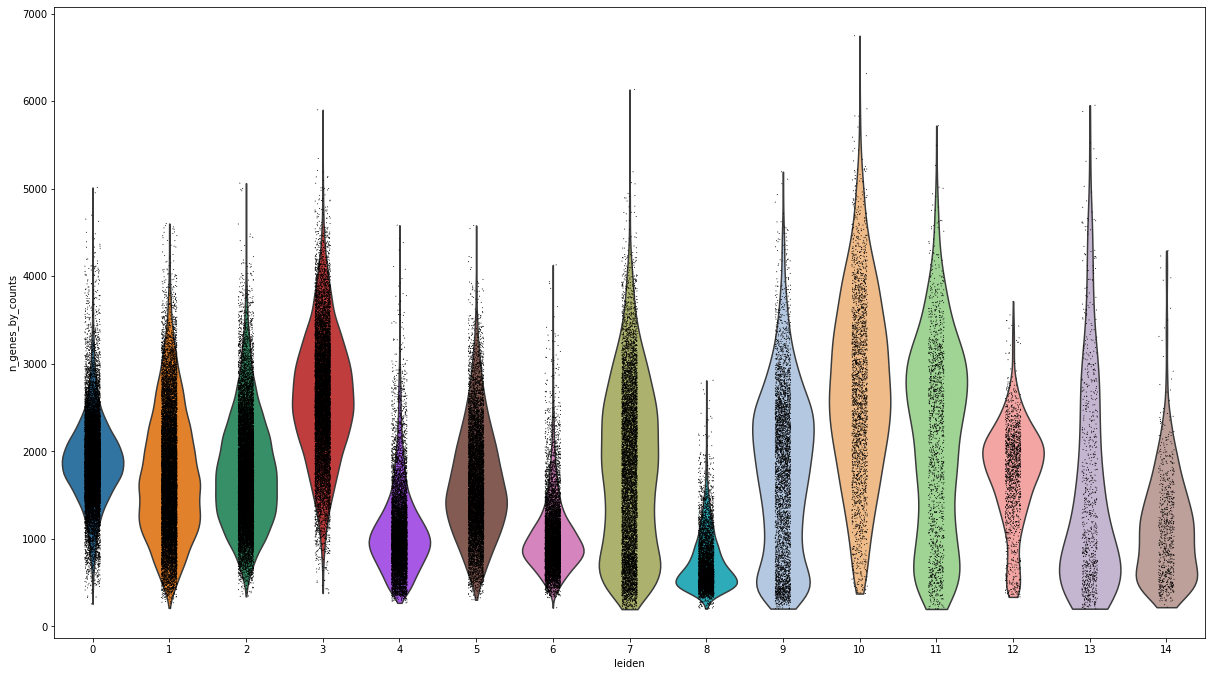

In [28]:
sc.pl.violin(ds, "n_genes_by_counts", "leiden")

Looks healthy, no additional filtering necessary

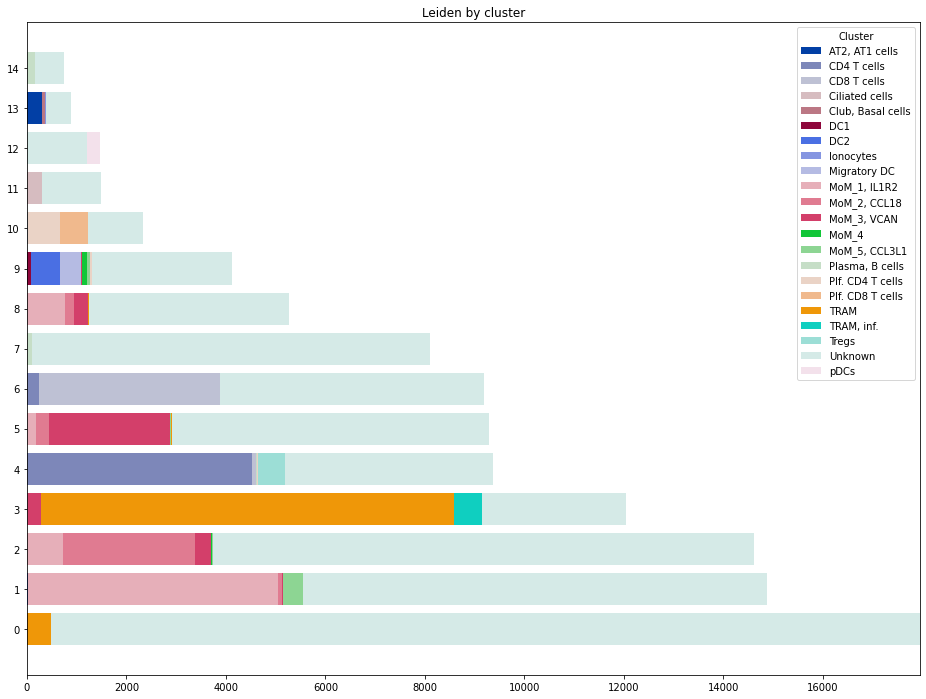

In [29]:
sc_utils.plot_composition(ds, "leiden", "cluster")

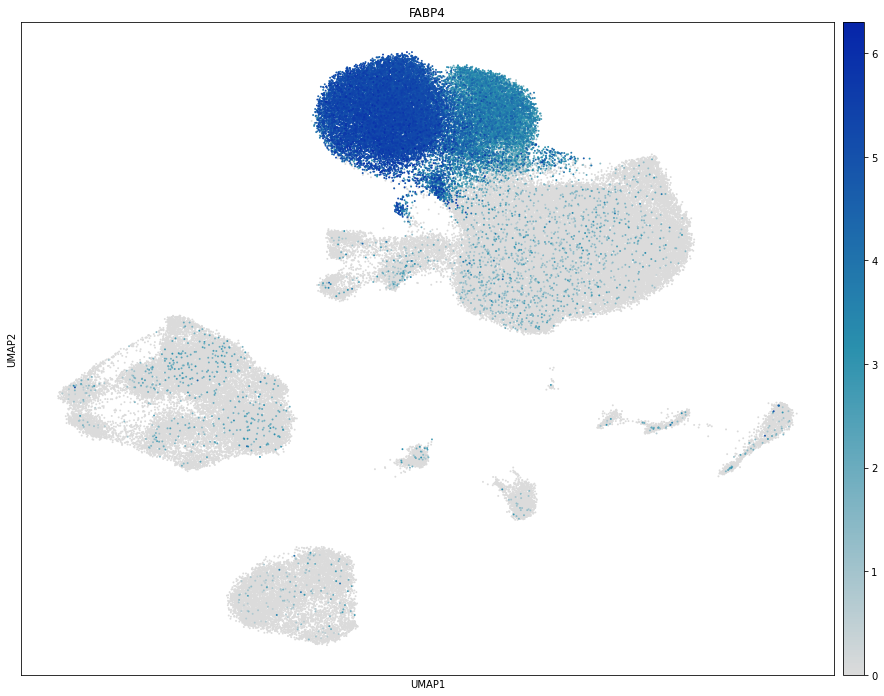

In [30]:
sc.pl.umap(ds, color="FABP4", size=15, cmap=sc_utils.expr_colormap())

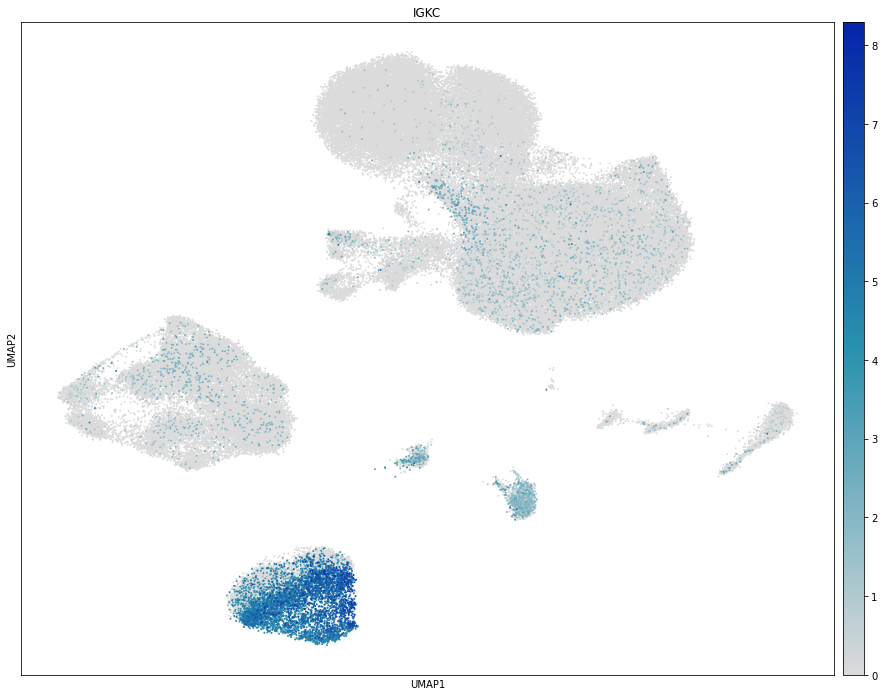

In [33]:
sc.pl.umap(ds, color="IGKC", size=15, cmap=sc_utils.expr_colormap())

## 1. Subcluster macrophages

In [27]:
macs = ds[ds.obs.leiden.isin(["0", "1", "2", "3", "5", "8"]), :]

In [28]:
macs = macs.raw.to_adata()

In [29]:
sc.pp.highly_variable_genes(macs, n_top_genes=2500, batch_key="orig.ident")

In [30]:
macs.var.highly_variable[macs.var_names.str.match("^SARS-CoV-2")] = False

/projects/b1038/Pulmonary/nmarkov/script/2020_Grant/single_cell_analysis/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
macs.raw = macs

In [32]:
sc.pp.scale(macs)
sc.tl.pca(macs, svd_solver="arpack")

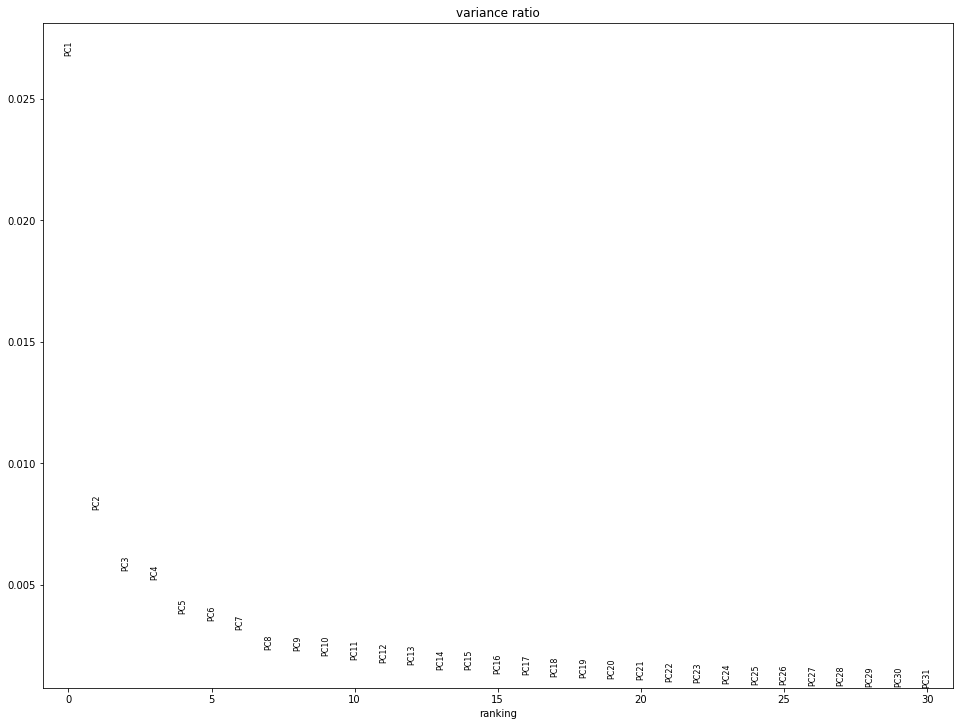

In [33]:
sc.pl.pca_variance_ratio(macs)

In [34]:
bbknn.bbknn(macs, neighbors_within_batch=int(100 / macs.obs.batch.unique().size), n_pcs=15)

In [35]:
sc.tl.leiden(macs, resolution=1)

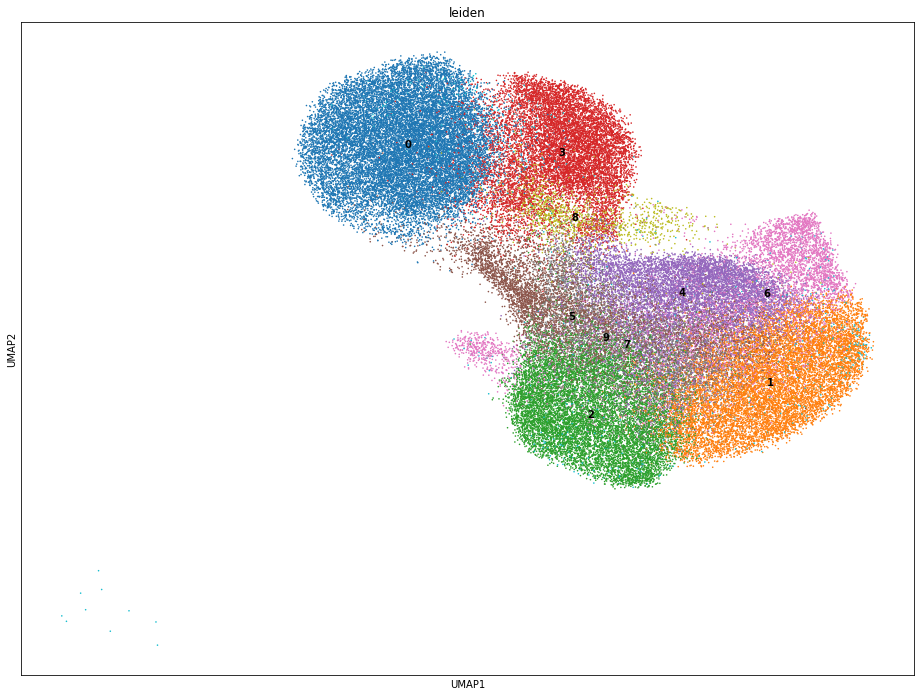

In [36]:
sc.pl.umap(macs, color="leiden", size=10, legend_loc="on data")

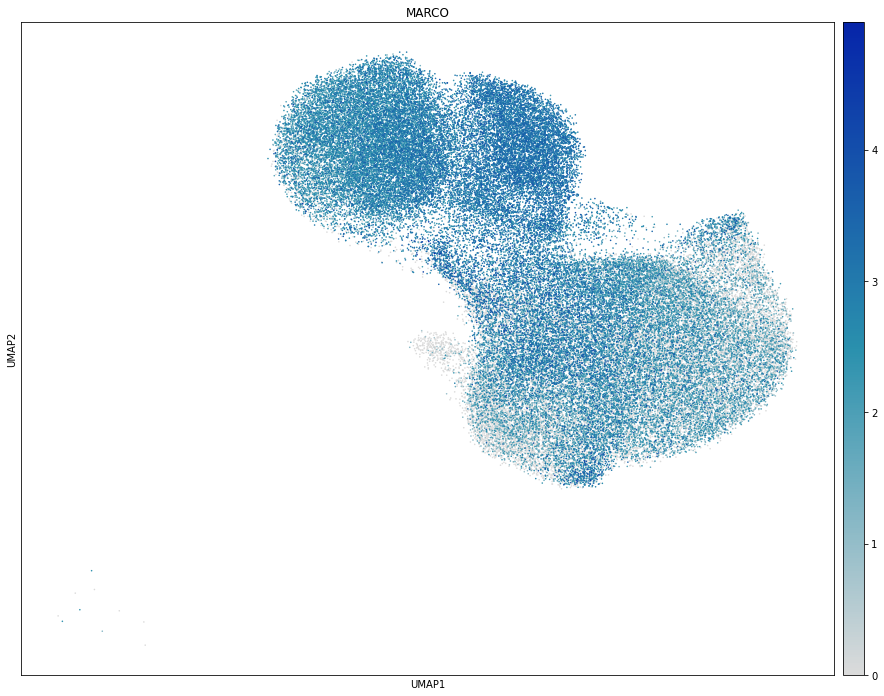

In [96]:
sc.pl.umap(macs, color="MARCO", size=10, cmap=sc_utils.expr_colormap())

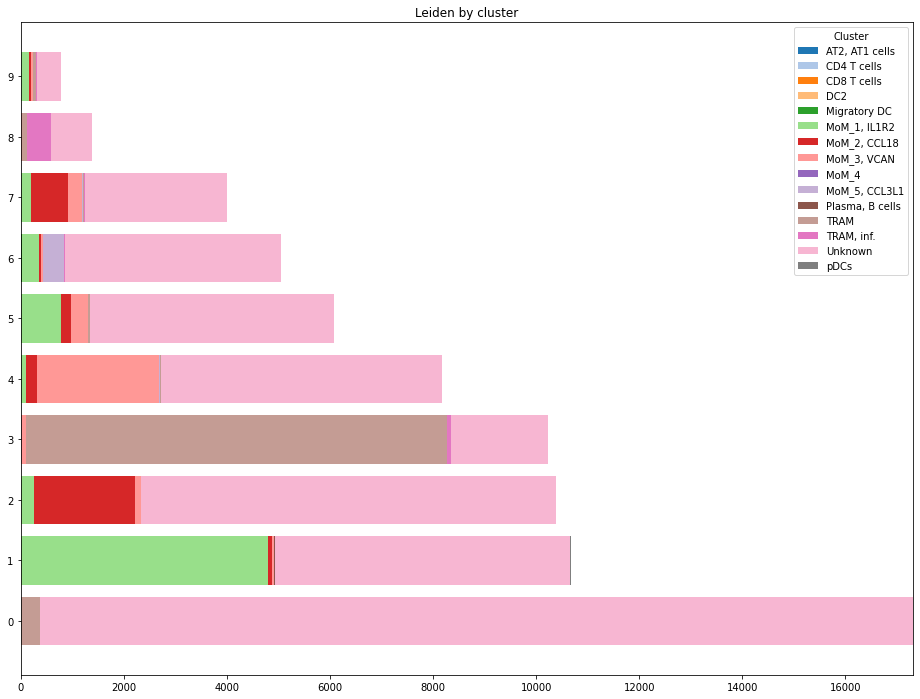

In [82]:
sc_utils.plot_composition(macs, "leiden", "cluster")

In [83]:
macs.obs.leiden[macs.obs.cluster == "TRAM, inf."].value_counts()

8    453
3     74
6     27
7     19
9     10
5      2
1      2
0      1
4      0
2      0
Name: leiden, dtype: int64

In [95]:
macs.obs.leiden[macs.obs.patient == 1276].value_counts()

5    1727
7      87
2      86
3      76
4      26
0      22
6      20
8       8
9       7
1       2
Name: leiden, dtype: int64

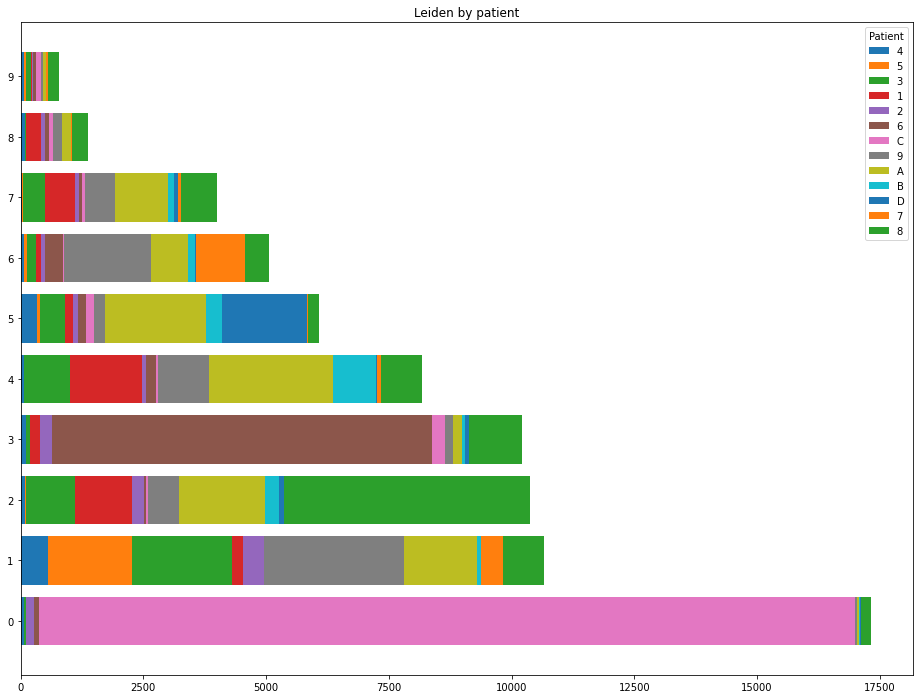

In [33]:
sc_utils.plot_composition(macs, "leiden", "patient")

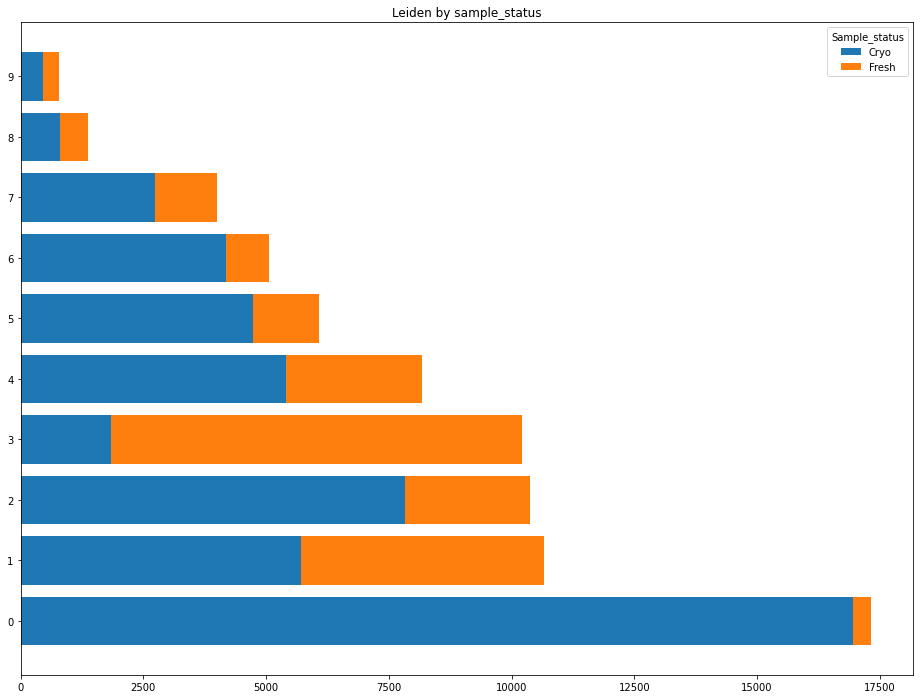

In [85]:
sc_utils.plot_composition(macs, "leiden", "sample_status")

New samples contributed to all populations, including TRAM2

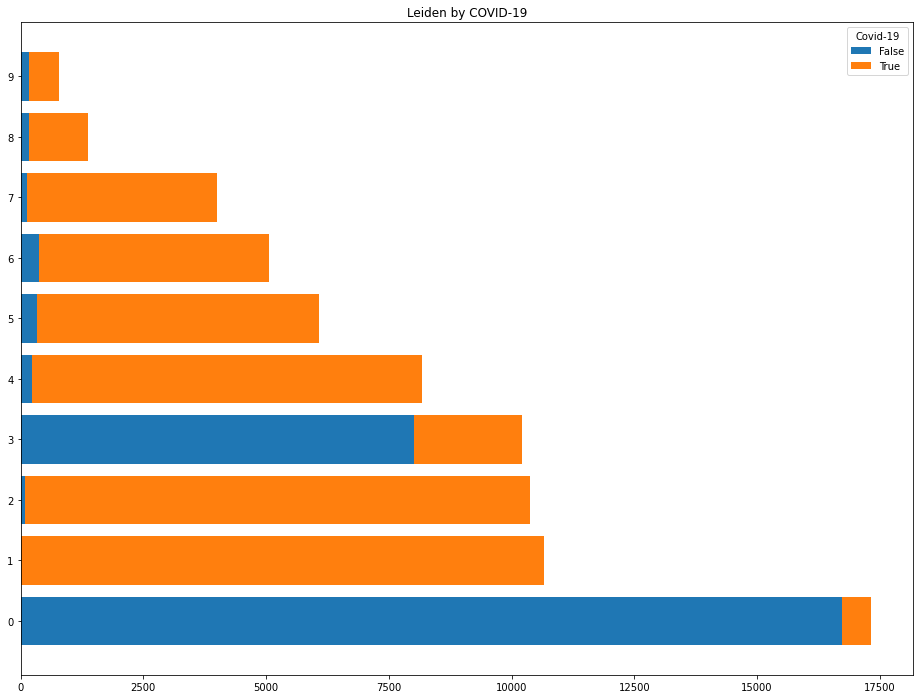

In [98]:
sc_utils.plot_composition(macs, "leiden", "COVID-19")

In [86]:
sc.tl.rank_genes_groups(macs, "leiden", method="wilcoxon", n_genes=200)
macs_markers = sc_utils.get_markers(macs, "leiden")

In [87]:
macs_markers.sort_values(
    "avg_logFC", 
    ascending=False
).groupby("cluster").head(20).sort_values(["cluster", "avg_logFC"], ascending=[True, False])

p_val  avg_logFC     pct.1     pct.2      p_val_adj cluster  \
0      0.000000e+00   7.056674  0.988856  0.227668   0.000000e+00       0   
18     0.000000e+00   5.656542  0.694768  0.048311   0.000000e+00       0   
9      0.000000e+00   5.424531  0.859395  0.164270   0.000000e+00       0   
13     0.000000e+00   4.843190  0.851657  0.165398   0.000000e+00       0   
30     0.000000e+00   4.618561  0.661335  0.063487   0.000000e+00       0   
11     0.000000e+00   4.406476  0.772780  0.110336   0.000000e+00       0   
14     0.000000e+00   4.200306  0.963853  0.267625   0.000000e+00       0   
113    0.000000e+00   4.064750  0.429784  0.046390   0.000000e+00       0   
7      0.000000e+00   4.006062  0.839242  0.162542   0.000000e+00       0   
24     0.000000e+00   3.964093  0.705335  0.110230   0.000000e+00       0   
67     0.000000e+00   3.900295  0.529507  0.072952   0.000000e+00       0   
6      0.000000e+00   3.818704  0.847557  0.175850   0.000000e+00       0   
19     0.000000e+00   3.684670  0.748585  0.149270   0.000000e+00       0   
50     0.000000e+00   3.606046  0.591697  0.098121   0.000000e+00       0   
1      0.000000e+00   3.570350  0.995842  0.664287   0.000000e+00       0   
167    0.000000e+00   3.467204  0.365516  0.053670   0.000000e+00       0   
12     0.000000e+00   3.367314  0.991512  0.720213   0.000000e+00       0   
47     0.000000e+00   3.287349  0.664395  0.147807   0.000000e+00       0   
90     0.000000e+00   3.252243  0.498383  0.095795   0.000000e+00       0   
17     0.000000e+00   3.168480  0.876025  0.251815   0.000000e+00       0   
200    0.000000e+00   4.292358  0.955291  0.331782   0.000000e+00       1   
218    0.000000e+00   4.277953  0.659762  0.114507   0.000000e+00       1   
207    0.000000e+00   4.103916  0.781423  0.153191   0.000000e+00       1   
274    0.000000e+00   4.036108  0.464992  0.055455   0.000000e+00       1   
214    0.000000e+00   3.928994  0.719561  0.153333   0.000000e+00       1   
215    0.000000e+00   3.741096  0.685350  0.126434   0.000000e+00       1   
213    0.000000e+00   3.489809  0.714781  0.165686   0.000000e+00       1   
201    0.000000e+00   3.489067  0.980692  0.679293   0.000000e+00       1   
202    0.000000e+00   3.400187  0.964945  0.453593   0.000000e+00       1   
245    0.000000e+00   3.260362  0.745243  0.312314   0.000000e+00       1   
210    0.000000e+00   3.097511  0.832787  0.315469   0.000000e+00       1   
310    0.000000e+00   3.054742  0.402474  0.076548   0.000000e+00       1   
203    0.000000e+00   2.955925  0.966913  0.774884   0.000000e+00       1   
299    0.000000e+00   2.938863  0.441091  0.097294   0.000000e+00       1   
216    0.000000e+00   2.916230  0.758834  0.298194   0.000000e+00       1   
204    0.000000e+00   2.890027  0.940013  0.538030   0.000000e+00       1   
247    0.000000e+00   2.857815  0.602025  0.146707   0.000000e+00       1   
205    0.000000e+00   2.796219  0.919486  0.502990   0.000000e+00       1   
208    0.000000e+00   2.718837  0.937201  0.531971   0.000000e+00       1   
206    0.000000e+00   2.700884  0.895210  0.510941   0.000000e+00       1   
400    0.000000e+00   3.579960  0.874097  0.305813   0.000000e+00       2   
420    0.000000e+00   3.447236  0.444370  0.072731   0.000000e+00       2   
408    0.000000e+00   3.086778  0.571429  0.145054   0.000000e+00       2   
554   1.373767e-189   3.042910  0.216068  0.037347  1.373767e-189       2   
585   3.932917e-148   3.014421  0.187073  0.028725  3.932917e-148       2   
441    0.000000e+00   2.999566  0.388691  0.087714   0.000000e+00       2   
471    0.000000e+00   2.851305  0.302476  0.054513   0.000000e+00       2   
403    0.000000e+00   2.631429  0.793565  0.329826   0.000000e+00       2   
404    0.000000e+00   2.492651  0.753781  0.371241   0.000000e+00       2   
416    0.000000e+00   2.474761  0.550718  0.164214   0.000000e+00       2   
536   4.678373e-214   2.403877  0.250361  0.062570  4.678373e-214       2   
569   1.35

Cluster 9 is T cells, we should remove them. 

Cluster 0, 3 is TRAM1 (healthy TRAMs)

Cluster 1 is MoAM1 (IL1R2, CD38, CCL2) 

Cluster 2 is MoAM2 (RNASE1, F13A1, LGMN, TREM2, CCL13)

Cluster 4 is MoAM3 (S100A8, VCAN, CD93, FCN1, CLU) 

Cluster 5 is ???? only marker genes as B cell genes, closest cluster on clustertree (see below) is T cells. All patient D cells are in here, both FABP4+ and FABP4-. Looks like it's low-counts cluster that picked up other low-count cells.

Cluster 6 is MoAM (G0S2, IL1B, TNF, **lots of great cytokines**, GPR84, TRAF1)

Cluster 7 is MoAM (GDF15, CSF1, PLPP3, SPP1, HAMP, PLA2G7)

Cluster 8 is TRAM2 (infected TRAMs, CXCL10, NUPR1, IL27, TNFSF10, SEPT4, CCL23)

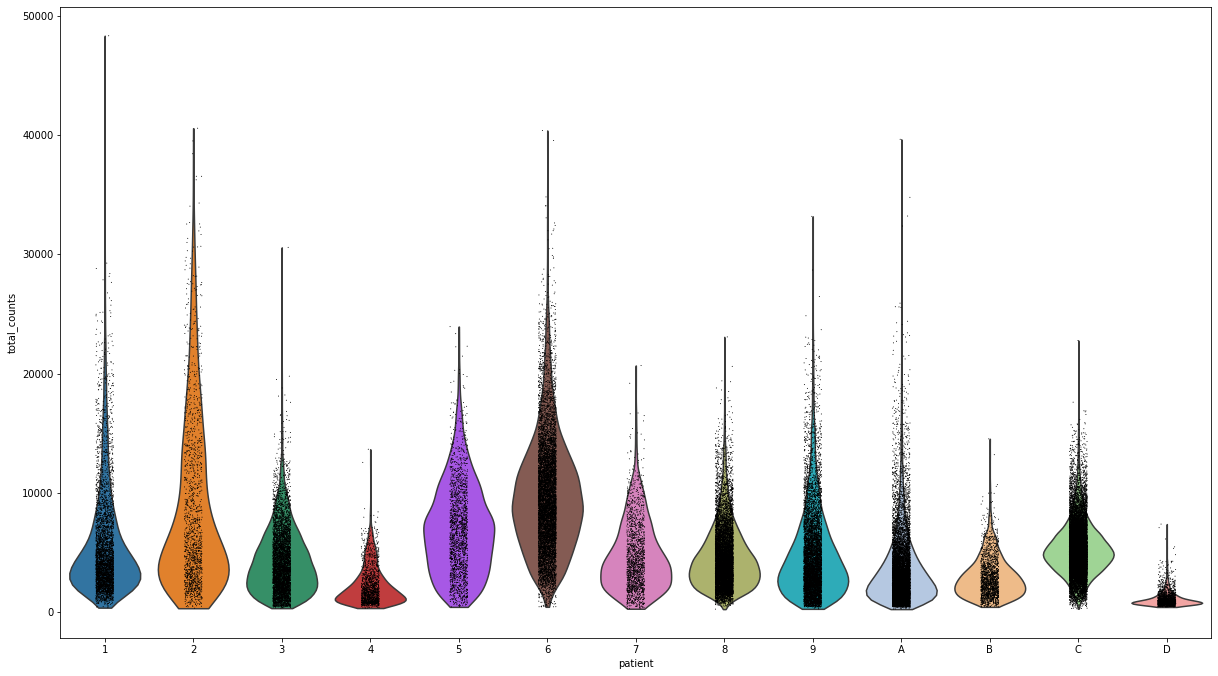

In [37]:
sc.pl.violin(macs, "total_counts", "patient")

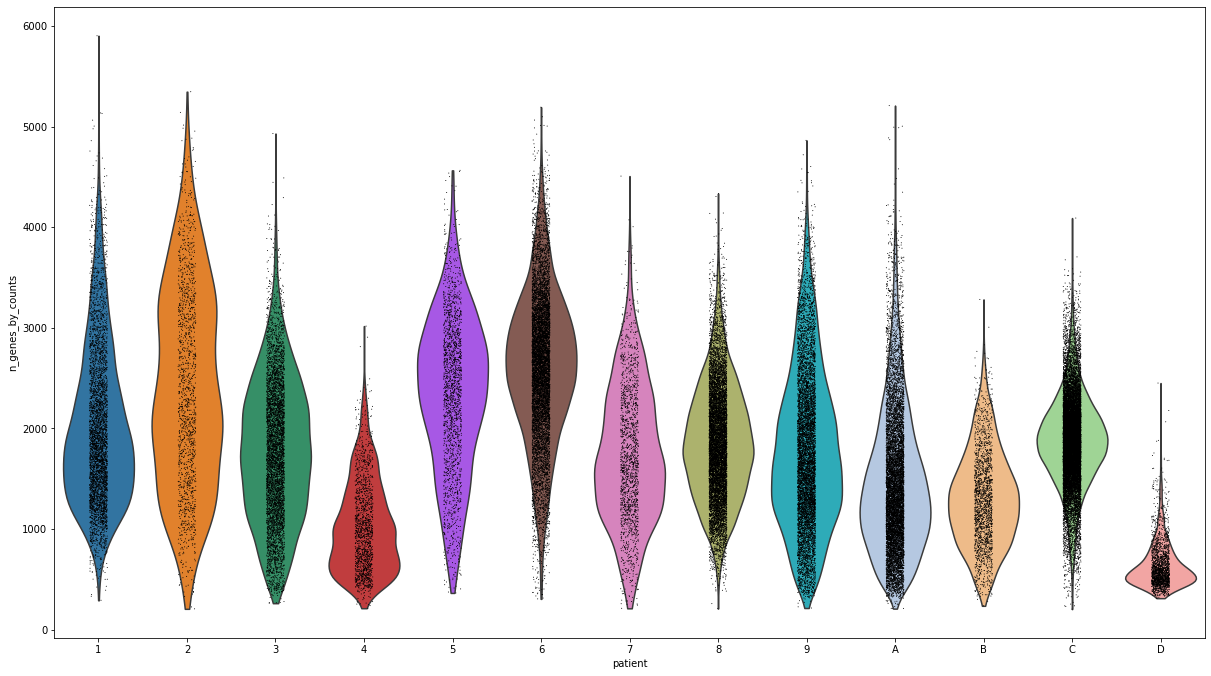

In [38]:
sc.pl.violin(macs, "n_genes_by_counts", "patient")

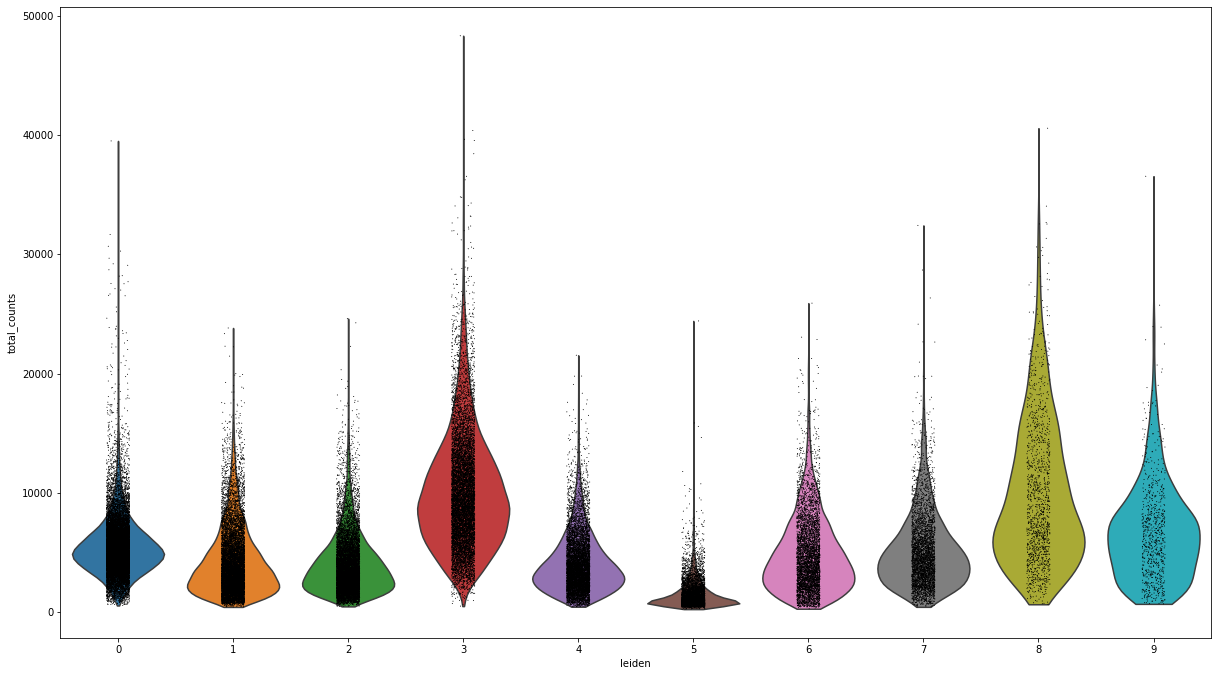

In [89]:
sc.pl.violin(macs, "total_counts", "leiden")

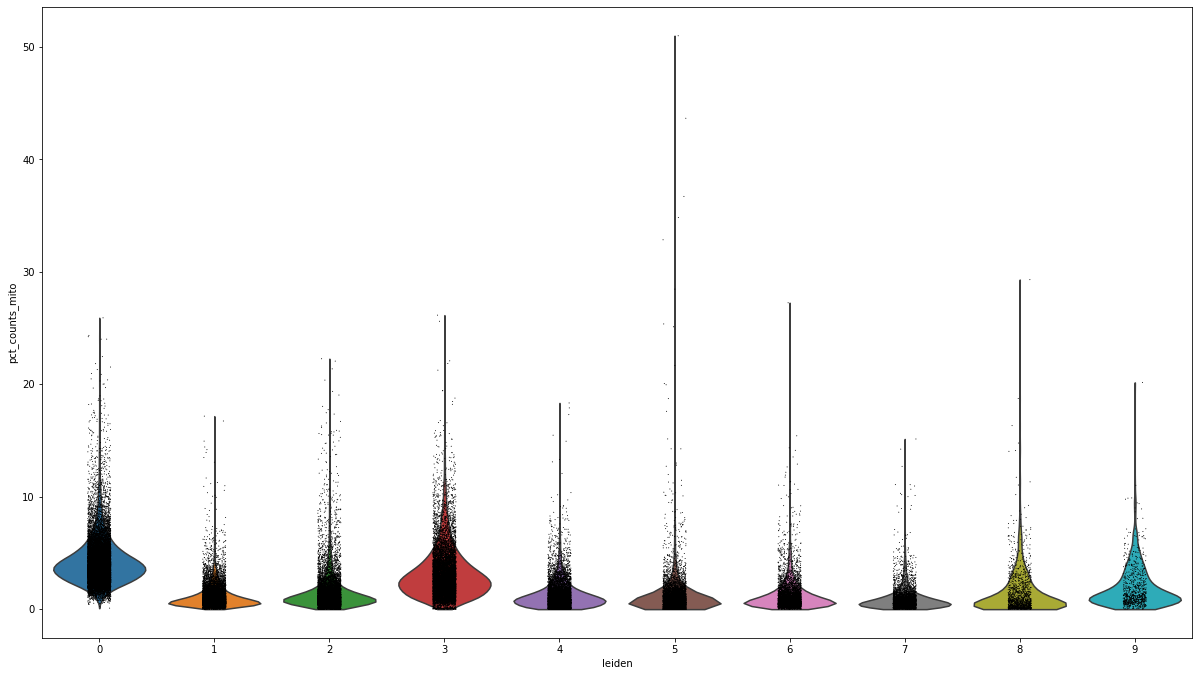

In [90]:
sc.pl.violin(macs, "pct_counts_mito", "leiden")

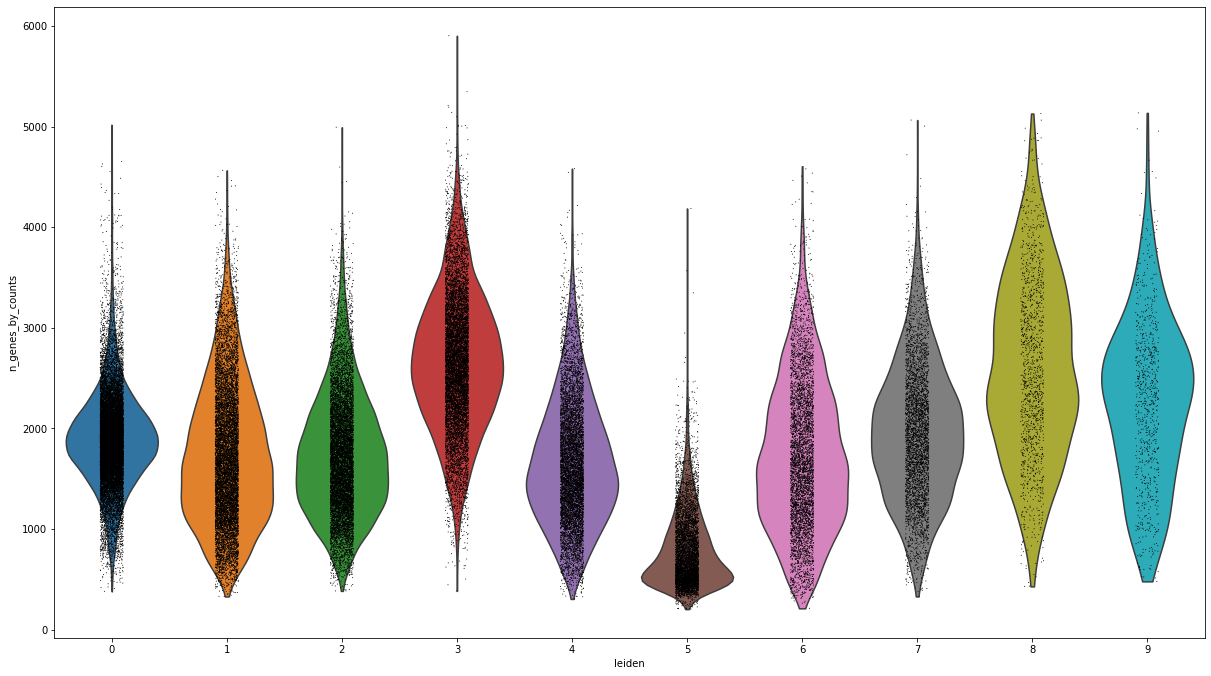

In [99]:
sc.pl.violin(macs, "n_genes_by_counts", "leiden")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Text(0.5, 1.0, 'Cluster 5 cells')

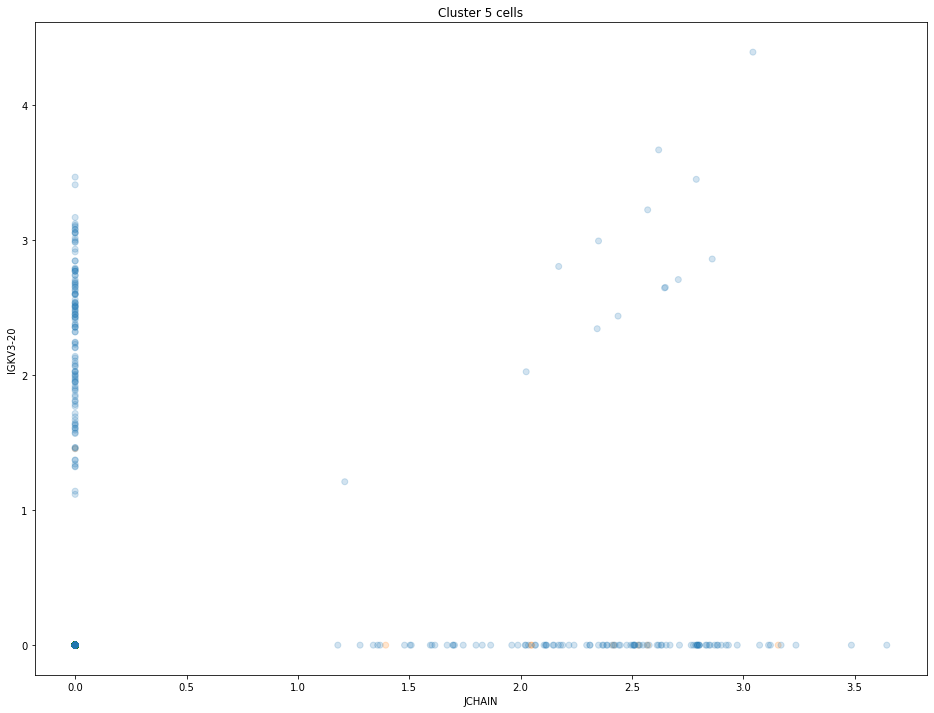

In [94]:
_c = sorted(macs.obs.sample_status.unique())
_c = dict(zip(_c, mpl.cm.tab10.colors[:len(_c)]))

fig, ax = plt.subplots()
ax.scatter(
    macs[macs.obs.leiden == "5", :].raw.X[:, macs.var_names == "JCHAIN"].todense().A.reshape(-1),
    macs[macs.obs.leiden == "5", :].raw.X[:, macs.var_names == "IGKV3-20"].todense().A.reshape(-1),
    c=macs[macs.obs.leiden == "5", :].obs.sample_status.astype(str).map(_c),
    alpha=0.2
)
ax.set_xlabel("JCHAIN")
ax.set_ylabel("IGKV3-20")
ax.set_title("Cluster 5 cells")

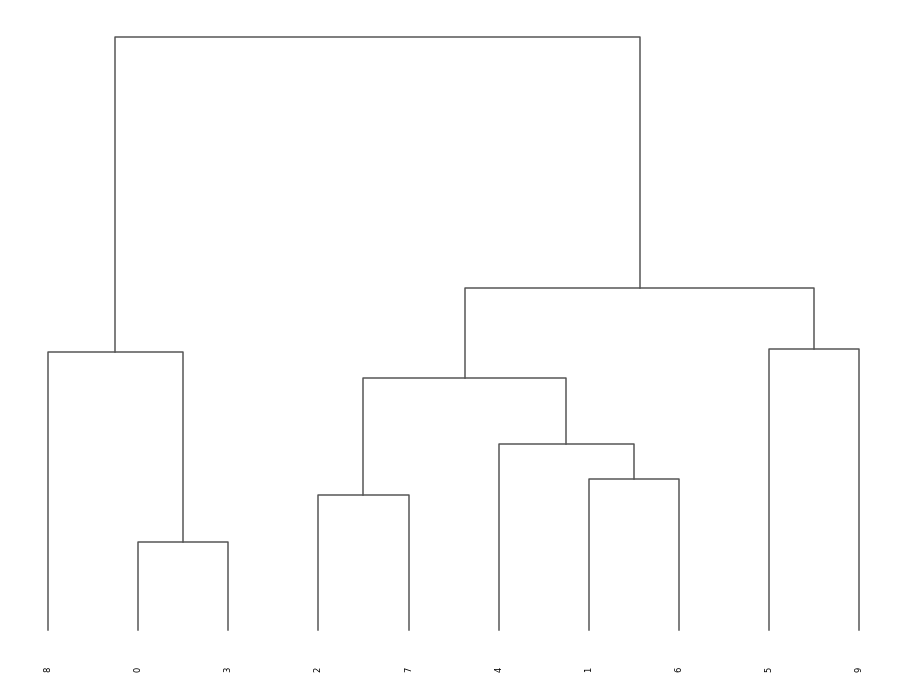

In [93]:
sc.tl.dendrogram(macs, "leiden")
sc.pl.dendrogram(macs, "leiden")

In [44]:
already_excluded = pd.read_csv("01cells-to-exclude.csv", index_col=0)

cells_to_exclude = pd.Series(macs.obs.index[macs.obs.leiden == "9"])

pd.concat([pd.Series(already_excluded.index), cells_to_exclude], axis=0).to_csv(
    "02cells-to-exclude.csv",
    index=False,
    header=False
)

## 1.5 Exploration of macrophage cluster 5

Because cluster 5 contained almost all macrophages from patient D, I want to explore this patient alone

In [142]:
pD = macs[macs.obs.patient == "D", :]

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [143]:
pD = pD.raw.to_adata()

In [144]:
sc.pp.highly_variable_genes(pD, n_top_genes=1500, batch_key="orig.ident")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:300: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:n_top_genes, 'highly_variable'] = True


In [145]:
pD.var.highly_variable[pD.var_names.str.match("^SARS-CoV-2")] = False

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [146]:
pD.raw = pD

In [147]:
sc.pp.scale(pD)
sc.tl.pca(pD, svd_solver="arpack")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


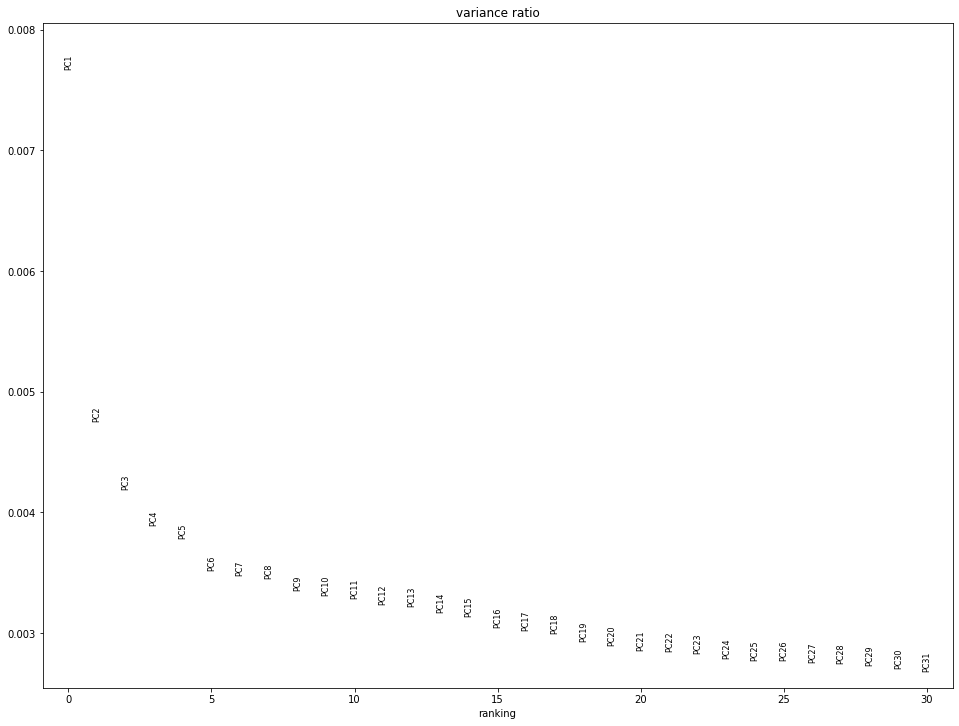

In [148]:
sc.pl.pca_variance_ratio(pD)

In [152]:
sc.pp.neighbors(pD, n_neighbors=15, n_pcs=15)

In [153]:
sc.tl.umap(pD)

In [154]:
sc.tl.leiden(pD, resolution=0.3)

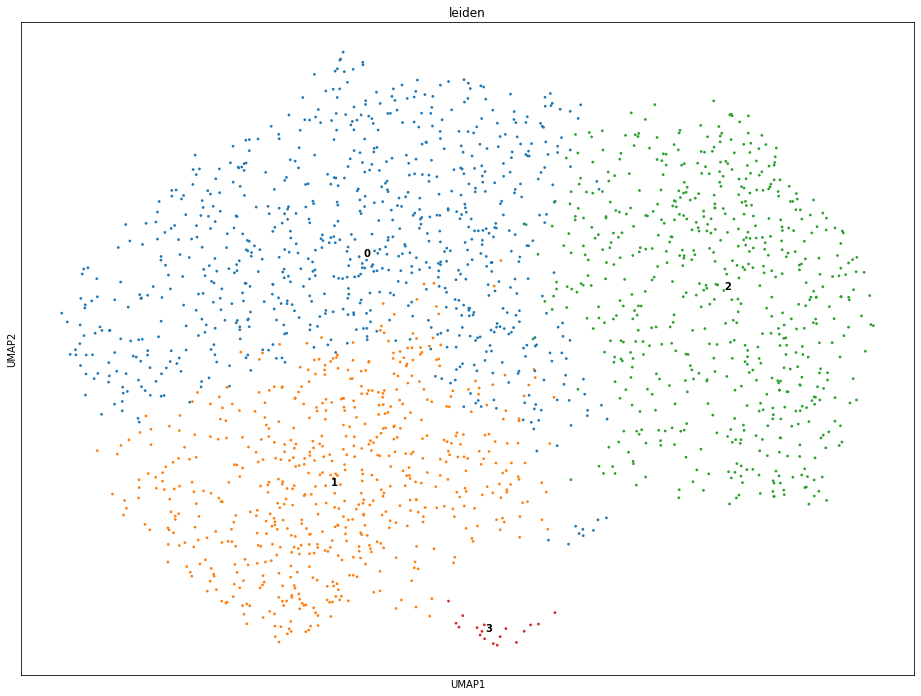

In [155]:
sc.pl.umap(pD, color="leiden", size=30, legend_loc="on data")

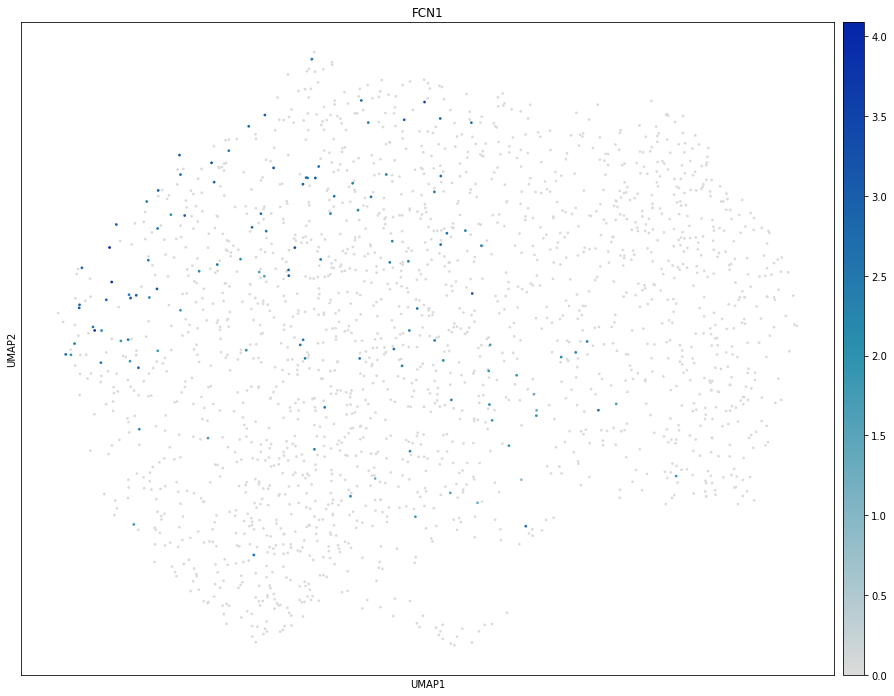

In [172]:
sc.pl.umap(pD, color="FCN1", size=30, cmap=sc_utils.expr_colormap())

In [156]:
sc.tl.rank_genes_groups(pD, "leiden", method="wilcoxon", n_genes=200)
pD_markers = sc_utils.get_markers(pD, "leiden")

In [157]:
pD_markers.sort_values(
    "avg_logFC", 
    ascending=False
).groupby("cluster").head(20).sort_values(["cluster", "avg_logFC"], ascending=[True, False])

p_val  avg_logFC     pct.1     pct.2      p_val_adj cluster  \
78    8.781505e-03   3.324605  0.121287  0.017814   8.781505e-03       0   
0     1.152084e-38   1.885999  0.698020  0.455870   1.152084e-38       0   
85    2.897076e-02   1.711479  0.155941  0.061538   2.897076e-02       0   
13    1.953428e-09   1.531082  0.347772  0.190283   1.953428e-09       0   
90    3.265149e-02   1.504673  0.184406  0.091498   3.265149e-02       0   
5     2.522436e-13   1.302120  0.481436  0.319838   2.522436e-13       0   
52    1.736760e-04   1.135054  0.292079  0.171660   1.736760e-04       0   
6     3.654926e-13   1.117217  0.570545  0.417004   3.654926e-13       0   
51    1.287537e-04   0.941604  0.356436  0.240486   1.287537e-04       0   
16    1.618278e-08   0.935656  0.516089  0.378947   1.618278e-08       0   
25    1.519498e-07   0.927352  0.613861  0.503644   1.519498e-07       0   
44    4.710379e-05   0.900632  0.383663  0.276923   4.710379e-05       0   
29    2.484745e-06   0.858192  0.465347  0.339271   2.484745e-06       0   
11    1.953428e-09   0.842375  0.641089  0.515789   1.953428e-09       0   
28    1.497586e-06   0.842034  0.487624  0.362753   1.497586e-06       0   
1     7.604947e-30   0.792284  0.924505  0.855870   7.604947e-30       0   
3     4.795335e-14   0.750073  0.823020  0.718219   4.795335e-14       0   
24    1.408563e-07   0.745444  0.642327  0.527935   1.408563e-07       0   
41    3.884421e-05   0.664425  0.530941  0.434818   3.884421e-05       0   
47    7.825990e-05   0.654192  0.599010  0.493117   7.825990e-05       0   
201   2.679366e-67   3.783562  0.591935  0.115249   2.679366e-67       1   
230   2.993008e-08   3.676572  0.200000  0.021082   2.993008e-08       1   
202   9.840355e-60   3.665899  0.554839  0.112439   9.840355e-60       1   
245   1.879811e-05   3.574464  0.164516  0.017569   1.879811e-05       1   
224   1.503612e-10   3.528082  0.229032  0.029515   1.503612e-10       1   
262   3.216135e-03   3.515654  0.130645  0.014758   3.216135e-03       1   
210   5.840800e-26   3.260669  0.369355  0.061841   5.840800e-26       1   
247   8.859510e-05   2.593444  0.175806  0.039353   8.859510e-05       1   
233   6.982555e-07   2.376358  0.217742  0.054111   6.982555e-07       1   
203   6.514661e-47   2.268291  0.646774  0.307098   6.514661e-47       1   
213   2.867972e-18   2.178012  0.412903  0.151792   2.867972e-18       1   
219   7.103495e-13   1.949855  0.343548  0.127196   7.103495e-13       1   
246   3.054922e-05   1.947679  0.212903  0.069571   3.054922e-05       1   
204   4.524449e-42   1.901733  0.727419  0.450457   4.524449e-42       1   
227   1.752799e-08   1.869768  0.282258  0.106114   1.752799e-08       1   
217   1.042248e-13   1.804376  0.400000  0.191145   1.042248e-13       1   
222   1.029301e-11   1.793306  0.346774  0.143359   1.029301e-11       1   
208   1.210122e-36   1.758689  0.737097  0.460998   1.210122e-36       1   
244   1.686684e-05   1.723946  0.233871  0.088545   1.686684e-05       1   
231   4.036958e-08   1.723175  0.288710  0.113844   4.036958e-08       1   
400  1.644555e-163   6.960967  0.798374  0.044818  1.644555e-163       2   
420   2.525532e-33   4.987974  0.369106  0.019608   2.525532e-33       2   
426   1.976181e-24   4.821305  0.317073  0.016106   1.976181e-24       2   
545   5.096900e-03   4.651169  0.117073  0.004202   5.096900e-03       2   
407   7.025994e-45   4.133592  0.495935  0.112745   7.025994e-45       2   
539   2.781185e-03   4.023623  0.125203  0.007003   2.781185e-03       2   
570   2.302232e-02   3.873699  0.108943  0.008403   2.302232e-02       2   
444   1.913458e-13   3.616580  0.253659  0.028011   1.913458e-13       2   
455   5.941021e-11   3.409217  0.232520  0.028711   5.941021e-11       2   
450   2.849042e-12   3.318914  0.248780  0.034314   2.849042e-12       2   
415   4.273750e-38   3.151824  0.655285  0.317227   4.273750e-38       2   
416   1.687242e-37   3.143318  0.456911  0.091737   1.687242e

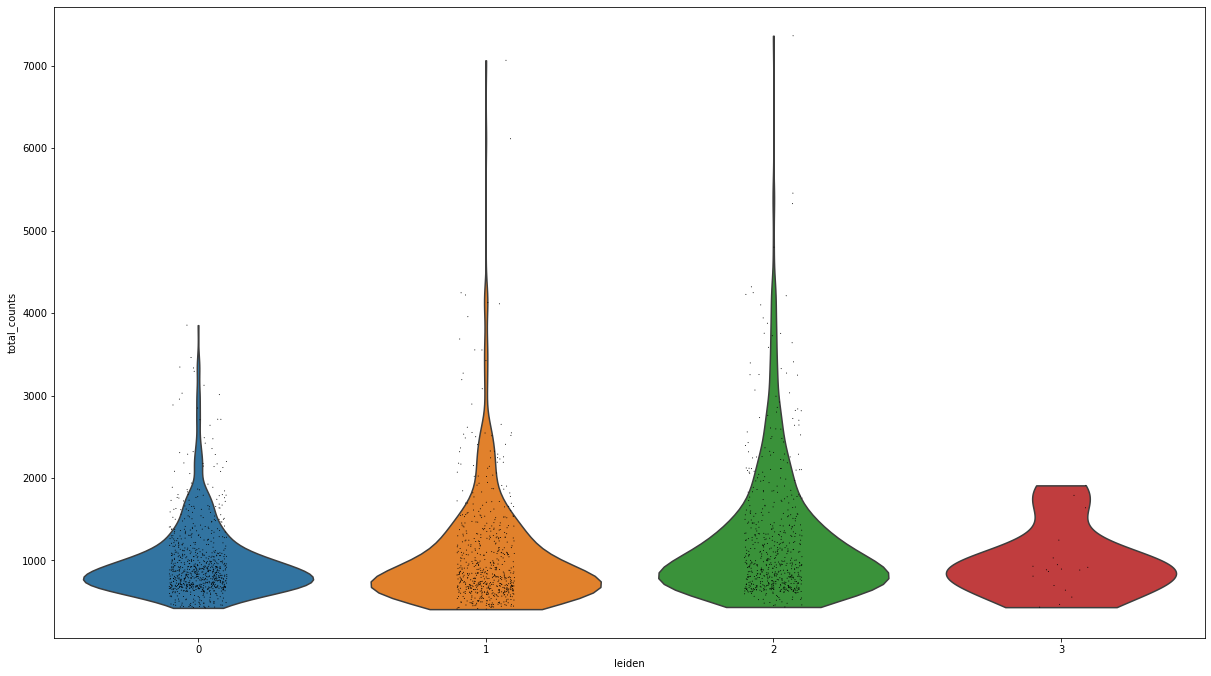

In [158]:
sc.pl.violin(pD, "total_counts", "leiden")

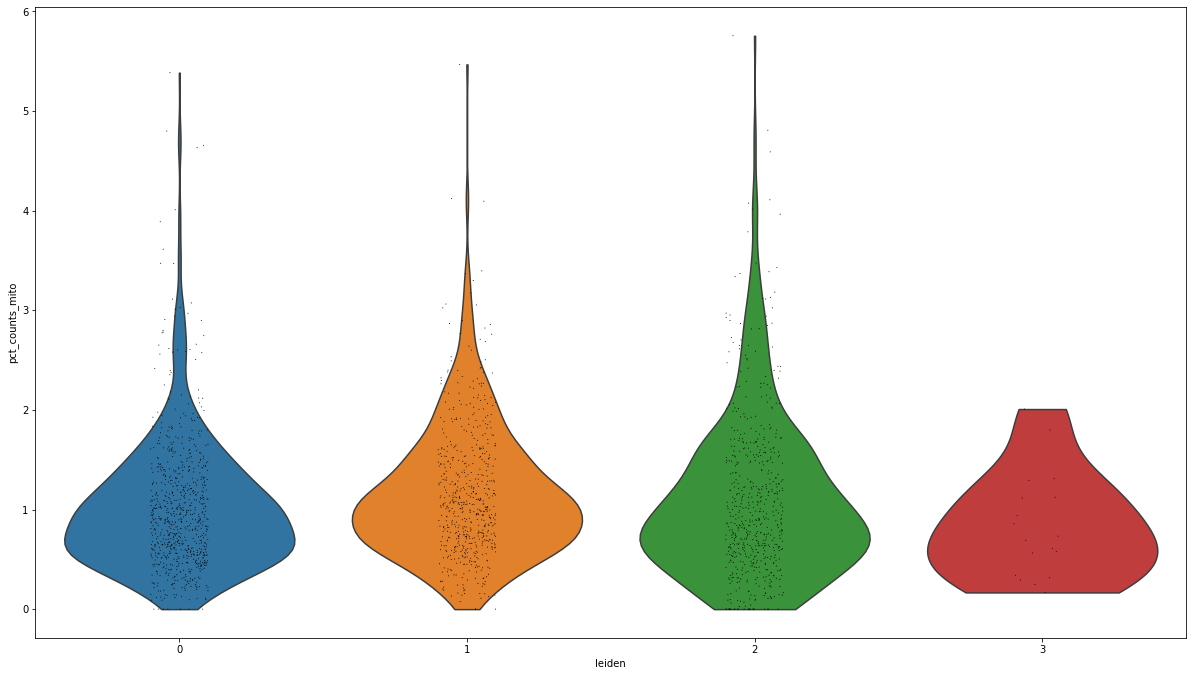

In [159]:
sc.pl.violin(pD, "pct_counts_mito", "leiden")

**Conclusion**: patient D has 3 distinct macrophage populations: (1) FABP4+, (2) RNASE1+, (3) FCN1+

However, our integration failed to integrate those cells with corresponding macrophage subtypes, likely because of major gap in technical parameters (very low mean nUMIs 1334 vs ~3787 mean).

Thus, we exclude this sample from analysis.

Viral reads from this patient:

... storing 'cluster' as categorical
... storing 'celltype' as categorical


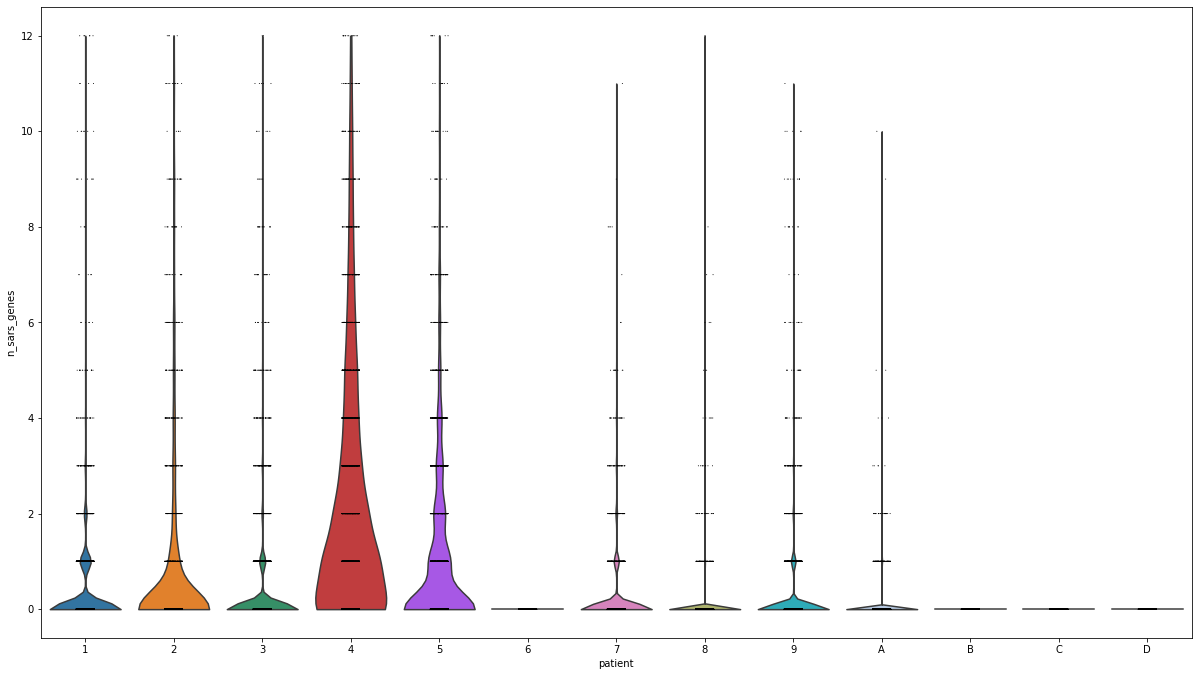

In [25]:
sc.pl.violin(ds, "n_sars_genes", "patient")